In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))

if module_path not in sys.path:
    sys.path.append(module_path)

from gridworld_env_layout import GridWorldMDPFromLayoutEnv
from gridworld_env import NoisyLinearRewardFeaturizedGridWorldEnv
import numpy as np
from agent.q_learning_agent import ValueIteration, PolicyEvaluation
from scipy.optimize import linprog

from utils.machine_teaching_utils import (build_Pi_from_q,
compute_successor_features_iterative_from_q,
 derive_constraints_from_q_ties, 
 remove_redundant_constraints,
 generate_candidates_from_q,
 plot_halfspace_intersection_2d,
 compare_regret_from_Q,
 sample_optimal_sa_pairs_like_scot,
)

from utils.mdp_generator import generate_random_gridworld_envs
from reward_learning.multi_env_birl import MultiEnvBIRL
from utils.common_helper import  bucket_and_dedup, calculate_expected_value_difference
from utils.env_helper import print_policy_from_q

### Making different mdps

In [2]:
W_TRUE = np.array([-10, -2]) / np.linalg.norm([-10, -2])

envs, meta = generate_random_gridworld_envs(
    n_envs=50,
    rows=3, cols=3,
    color_to_feature_map={"red":[1.0,0.0], "blue":[0.0,1.0]},
    palette=("red","blue"),
    p_color_range={"red":(0.2,0.6), "blue":(0.4,0.8)},
    terminal_policy=dict(kind="random_k", k_min=0, k_max=1, p_no_terminal=0.1),
    gamma_range=(0.98, 0.995),
    noise_prob_range=(0.0, 0.0),
    w_mode="fixed",
    W_fixed=W_TRUE,
    seed=45,
    GridEnvClass=GridWorldMDPFromLayoutEnv,
)

vis = [ValueIteration(env) for env in envs]
envs_V = [vi.run_value_iteration(epsilon=1e-10) for vi in vis]
envs_Q = [vi.get_q_values() for vi in vis]

In [3]:
envs[15].layout

[['blue', 'red', 'blue'], ['blue', 'blue', 'red'], ['red', 'blue', 'blue']]

In [4]:
# envs = envs[:]
# vis = vis[:]
# envs_V = envs_V[:]
# envs_Q = envs_Q[:]

In [5]:
# W_TRUE = np.array([-10, -2])/np.linalg.norm([-10, -2])

# layout_1 = [
#     ["blue",  "red", "blue"],
#     ["blue", "blue",  "blue"],
# ]

# layout_2 = [
#     ["blue",  "red", "blue"],
#     ["red", "blue",  "blue"],
# ]

# layout_3 = [
#     ["blue",  "red", "blue"],
#     ["blue", "red",  "blue"],
# ]

# layout_4 = [
#     ["blue",  "blue", "red"],
#     ["blue", "blue",  "blue"],
# ]

# layout_5 = [
#     ["blue",  "red", "blue"],
#     ["blue", "red",  "blue"],
# ]


# color_to_feature_map = {
#     "red":  [1.0, 0.0],
#     "blue": [0.0, 1.0],
# }

# rows, cols = 2, 3

# env_5 = GridWorldMDPFromLayoutEnv(
#     gamma=0.99,
#     layout=layout_1,
#     color_to_feature_map=color_to_feature_map,
#     noise_prob=0,
#     terminal_states=[0],
#     custom_feature_weights=W_TRUE,
#     render_mode=None,
# )

# env_2 = GridWorldMDPFromLayoutEnv(
#     gamma=0.99,
#     layout=layout_2,
#     color_to_feature_map=color_to_feature_map,
#     noise_prob=0,
#     terminal_states=[1],
#     custom_feature_weights=W_TRUE,
#     render_mode=None,
# )

# env_3 = GridWorldMDPFromLayoutEnv(
#     gamma=0.99,
#     layout=layout_3,
#     color_to_feature_map=color_to_feature_map,
#     noise_prob=0,
#     terminal_states=[2],
#     custom_feature_weights=W_TRUE,
#     render_mode=None,
# )

# env_4 = GridWorldMDPFromLayoutEnv(
#     gamma=0.99,
#     layout=layout_4,
#     color_to_feature_map=color_to_feature_map,
#     noise_prob=0,
#     terminal_states=[3],
#     custom_feature_weights=W_TRUE,
#     render_mode=None,
# )

# env_1 = GridWorldMDPFromLayoutEnv(
#     gamma=0.99,
#     layout=layout_5,
#     color_to_feature_map=color_to_feature_map,
#     noise_prob=0,
#     terminal_states=[0],
#     custom_feature_weights=W_TRUE,
#     render_mode=None,
# )

# envs = [env_1, env_2, env_3, env_4, env_5]

# vis = [ValueIteration(env) for env in envs]

# envs_V = [vi.run_value_iteration(epsilon=1e-10) for vi in vis]

# envs_Q = [vi.get_q_values() for vi in vis]

In [6]:
# import numpy as np

# # True reward: strongly dislike red, slightly dislike blue
# W_TRUE = np.array([-10.0, -1.0])  # red: -10, blue: -1
# # No need to normalize for the env, but we can if you want
# # W_TRUE = W_TRUE / np.linalg.norm(W_TRUE)

# color_to_feature_map = {
#     "red":  [1.0, 0.0],
#     "blue": [0.0, 1.0],
# }

# # ============================================================
# # MDP 1: Horizontal path — only sees red vs blue horizontally
# # ============================================================
# # Layout:
# # [S] [red] [G]
# # Only one path: right through red to goal
# # Optimal: go right (but red is costly)
# # This teaches: red is worse than blue → w[0] < w[1] ⇒ w[0] < 0 if blue is 0-reference

# layout_1 = [
#     ["blue", "red", "blue"]   # state 0: start, state 1: red, state 2: goal
# ]

# env_horizontal = GridWorldMDPFromLayoutEnv(
#     gamma=0.99,
#     layout=layout_1,
#     color_to_feature_map=color_to_feature_map,
#     noise_prob=0.0,
#     terminal_states=[2],  # goal is index (0,2) → state 2
#     custom_feature_weights=W_TRUE,
#     render_mode=None,
# )

# # ============================================================
# # MDP 2: Choice between red (up) and goal (right)
# # ============================================================
# # Layout 2x3:
# # [S] [ ] [G]
# # [ ] [red] [ ]
# #
# # Start at (0,0), goal at (0,2)
# # From state (1,1) = red, agent can go up to (0,1) or right to (0,2)=G
# # But there's a key state: let's put start at (1,0), and red at (1,1)
# # Better: force a choice

# layout_2 = [
#     ["blue", "blue", "blue"],   # row 0: 0=S, 1=, 2=G
#     ["blue", "red",  "blue"],   # row 1: 3=, 4=red, 5=
# ]

# # Start at bottom-left (1,0)=state 3, goal top-right (0,2)=state 2
# # Optimal path: up to (0,0), right to (0,1), right to G
# # But at state (1,1)=red, agent could go up to (0,1) or left/right
# # We need a state where two actions are compared

# # Best: start at (1,0), red at (1,1), goal at (0,2)
# # From (1,1), going up goes to (0,1) [blue], right goes to (0,2) [blue] but goal

# # Let's make it clear:
# # Start at state 3 (1,0), from there can go up to state 0 (blue) or right to state 4 (red)
# # From state 4 (red), can go up to state 1 (blue) or left back

# # So at state 3: choosing right (to red) vs up (to blue then goal)
# # This creates: mu_right - mu_up = feature(red) - feature(blue) = [1,0] - [0,1] = [1,-1]

# env_choice = GridWorldMDPFromLayoutEnv(
#     gamma=0.99,
#     layout=layout_2,
#     color_to_feature_map=color_to_feature_map,
#     noise_prob=0.0,
#     terminal_states=[2],  # goal is (0,2)
#     custom_feature_weights=W_TRUE,
#     render_mode=None,
# )

# # ============================================================
# # Full list
# # ============================================================
# envs = [env_horizontal, env_choice]

# # Solve
# envs_V = [ValueIteration(env) for env in envs]
# for vi in vis:
#     vi.run_value_iteration(epsilon=1e-10)

# envs_Q = [vi.get_q_values() for vi in vis]

In [7]:
for i, env in enumerate(envs):

    print_policy_from_q(envs_Q[i], rows=env.rows, cols=env.columns, tie_eps=1e-8, terminal_states=env.terminal_states)

^v<> | ^v<> | ^v<>
^<>  | ^v<> | ^v<>
^>   | ^v>  | ^v<>

^v< | v<> | ^> 
^<> | <   | ^v<
^   | ^>  | v> 

^<>  | ^v<  | v<  
^v>  | ^v>  | v<> 
v<>  | ^v<> | ^v<>

>    | ^v>  | ^v<>
v>   | ^v>  | ^<> 
v<>  | ^v<  | ^<  

v>  | ^v  | v< 
<>  | ^<> | v<>
^   | ^>  | ^v>

^v<> | ^v<> | ^<> 
^v<> | ^v<  | ^<  
^v<> | ^v<  | <   

v  | v  | v 
T  | <  | < 
^  | ^  | ^<

v>   | ^>   | ^v<>
v<   | ^v<> | ^v> 
^v<> | v<>  | ^v<>

>  | >  | T 
^> | ^> | ^ 
^> | ^> | ^ 

v | < | v
v | < | v
T | < | <

v  | >  | v 
v> | v> | v 
>  | >  | T 

>  | T  | < 
^> | ^  | ^<
^> | ^  | ^<

v  | v  | v 
>  | T  | < 
^> | ^  | ^<

>  | >  | ^>
v> | v  | ^ 
>  | v  | < 

>   | ^   | <  
^v> | ^v  | ^v<
>   | v   | <  

v  | v  | v<
>  | v  | v<
>  | T  | < 

v  | <  | < 
T  | <  | < 
^  | ^< | ^ 

^<> | ^<  | <  
^v  | ^   | ^< 
v<  | <   | <  

v>   | ^v   | v<  
<>   | ^v<> | v<> 
^>   | ^v>  | ^v<>

>  | v  | v<
v> | v  | < 
>  | T  | < 

^v<> | ^<>  | ^v<>
^v<  | ^<>  | ^v> 
^v<  | <>   | ^v> 

v> | v 

In [ ]:
def build_Pi_from_q_family(envs, Q_list, tie_eps=1e-10):
    Pis = []
    for env, q in zip(envs, Q_list):
        Pis.append(build_Pi_from_q(env, q, tie_eps=tie_eps))
    return Pis

def compute_successor_features_family(envs, Q_list, **kw):
    out = []
    for env, q in zip(envs, Q_list):
        mu_sa, mu_s, Phi, P_pi = compute_successor_features_iterative_from_q(env, q, **kw)
        out.append((mu_sa, mu_s, Phi, P_pi))
    return out

def derive_constraints_family(SFs, Q_list, envs, tie_eps=1e-10,
                              skip_terminals=True, normalize=True, tol=1e-12,
                              precision=1e-3, lp_epsilon=1e-4):
    U_per_mdp = []
    all_H = []
    for (mu_sa, _, _, _), q, env in zip(SFs, Q_list, envs):
        cons = derive_constraints_from_q_ties(mu_sa, q, env,
                                              tie_eps=tie_eps,
                                              skip_terminals=skip_terminals,
                                              normalize=normalize, tol=tol)
        H_i = [c[0] if isinstance(c, tuple) else c for c in cons]  # keep vectors
        U_per_mdp.append(H_i)
        all_H.extend(H_i)

    # spherical dedup by cosine threshold
    pre = []
    for v in all_H:
        if not any(np.dot(v, u) / (np.linalg.norm(v)*np.linalg.norm(u)) > 1-precision for u in pre):
            pre.append(v)

    # LP redundancy removal on the family set (your existing routine)
    U_global = np.array(remove_redundant_constraints(pre, epsilon=lp_epsilon))
    return U_per_mdp, U_global

# def derive_constraints_family_unique_per_mdp(SFs, Q_list, envs, tie_eps=1e-10,
#                               skip_terminals=True, normalize=True, tol=1e-12,
#                               precision=1e-3, lp_epsilon=1e-4):
#     U_per_mdp = []
#     all_H = []
#     for (mu_sa, _, _, _), q, env in zip(SFs, Q_list, envs):
#         cons = derive_constraints_from_q_ties(mu_sa, q, env,
#                                               tie_eps=tie_eps,
#                                               skip_terminals=skip_terminals,
#                                               normalize=normalize, tol=tol)
#         H_i = [c[0] if isinstance(c, tuple) else c for c in cons]  # keep vectors
        
#         #U_per_mdp.append(H_i)
#         H_i = np.array(remove_redundant_constraints(H_i, epsilon=lp_epsilon))
#         U_per_mdp.append(H_i)
#         all_H.extend(H_i)

#     # spherical dedup by cosine threshold
#     pre = []
#     for v in all_H:
#         if not any(np.dot(v, u) / (np.linalg.norm(v)*np.linalg.norm(u)) > 1-precision for u in pre):
#             pre.append(v)

#     # LP redundancy removal on the family set (your existing routine)
#     #U_global = np.array(remove_redundant_constraints(pre, epsilon=lp_epsilon))
#     U_global = np.array(pre)
#     return U_per_mdp, U_global

def generate_candidates_from_q_family(envs, Q_list, **kw):
    C = []
    for env, q in zip(envs, Q_list):
        C.append(generate_candidates_from_q(env, q, **kw))
    return C

def scot_greedy_family_unweighted(
    U_global,       # np.ndarray of unit normals in R^d (family universe)
    candidates,     # List[List[Traj]] per MDP: candidates[i] = list of trajectories for MDP i
    SFs,            # List[(mu_sa, mu_s, Phi, P_pi)] per MDP; we use mu_sa only
    normalize=True,
    round_decimals=12,
):
    """
    Unweighted greedy set cover over family constraints.
    Returns:
        chosen: List[(mdp_index, trajectory)] until U_global is covered or no progress possible.
    """
    m = len(candidates)
    mu_sa_list = [sf[0] for sf in SFs]  # (S_i, A_i, d)

    # stable key for a direction vector
    def key_for(v):
        n = np.linalg.norm(v)
        if not np.isfinite(n) or n == 0.0:
            return ("ZERO",)
        vv = v / n if normalize else v
        return tuple(np.round(vv, round_decimals))

    # index universe by direction key
    key_to_uix = {}
    for idx, v in enumerate(U_global):
        key_to_uix.setdefault(key_for(v), []).append(idx)

    universe = set(range(len(U_global)))
    covered  = set()
    chosen   = []

    # precompute coverage set for each candidate trajectory (against U_global)
    cov = [[set() for _ in cand_i] for cand_i in candidates]
    for i, (cand_i, mu_sa) in enumerate(zip(candidates, mu_sa_list)):
        S_i, A_i, _ = mu_sa.shape
        for j, tau in enumerate(cand_i):
            covered_by_tau = set()
            for (s, a) in tau:
                psi_star = mu_sa[s, a]
                for b in range(A_i):
                    if b == a:
                        continue
                    v = psi_star - mu_sa[s, b]
                    k = key_for(v)
                    if k in key_to_uix:
                        covered_by_tau.update(key_to_uix[k])
            cov[i][j] = covered_by_tau

    # greedy loop: pick the candidate with the largest new coverage
    while True:
        uncovered = universe - covered
        if not uncovered:
            break

        best_gain = 0
        best_item = None
        best_new  = None

        for i in range(m):
            for j in range(len(candidates[i])):
                if not cov[i][j]:
                    continue
                new_cover = uncovered & cov[i][j]
                gain = len(new_cover)
                if gain > best_gain:
                    best_gain, best_item, best_new = gain, (i, j), new_cover

        if best_item is None:  # no candidate adds new coverage
            break

        i, j = best_item
        chosen.append((i, candidates[i][j]))
        covered |= best_new

    return chosen

In [ ]:
SFs = compute_successor_features_family(
    envs,
    envs_Q,
    convention="entering",
    zero_terminal_features=True,
    tol=1e-10,
    max_iters=10000,
)

U_per_mdp, U_global = derive_constraints_family(
    SFs,
    envs_Q,
    envs,
    tie_eps=1e-10,
    skip_terminals=True,
    normalize=True,
    tol=1e-12,
    precision=1e-3,
    lp_epsilon=1e-4,
)

# U_per_mdp_, U_global_ = derive_constraints_family_unique_per_mdp(
#     SFs,
#     envs_Q,
#     envs,
#     tie_eps=1e-10,
#     skip_terminals=True,
#     normalize=True,
#     tol=1e-12,
#     precision=1e-3,
#     lp_epsilon=1e-4,
# )

# (Optional) If you want to quickly visualize constraints before demos:
# my_visualize_constraints(U_per_mdp=U_per_mdp, U_global=U_global, envs=envs)

Pi from q:  [[0.25       0.25       0.25       0.25      ]
 [0.25       0.25       0.25       0.25      ]
 [0.25       0.25       0.25       0.25      ]
 [0.33333333 0.         0.33333333 0.33333333]
 [0.25       0.25       0.25       0.25      ]
 [0.25       0.25       0.25       0.25      ]
 [0.5        0.         0.         0.5       ]
 [0.33333333 0.33333333 0.         0.33333333]
 [0.25       0.25       0.25       0.25      ]]
Pi from q:  [[0.33333333 0.33333333 0.33333333 0.        ]
 [0.         0.33333333 0.33333333 0.33333333]
 [0.5        0.         0.         0.5       ]
 [0.33333333 0.         0.33333333 0.33333333]
 [0.         0.         1.         0.        ]
 [0.33333333 0.33333333 0.33333333 0.        ]
 [1.         0.         0.         0.        ]
 [0.5        0.         0.         0.5       ]
 [0.         0.5        0.         0.5       ]]
Pi from q:  [[0.33333333 0.         0.33333333 0.33333333]
 [0.33333333 0.33333333 0.33333333 0.        ]
 [0.         0.5      

In [12]:
U_global_

array([[-0.70710678,  0.70710678],
       [ 0.        , -1.        ],
       [-0.32017536,  0.9473583 ],
       [-0.99989118,  0.01475222]])

In [13]:
U_global

array([[ 0.        , -1.        ],
       [-0.32017536,  0.9473583 ]])

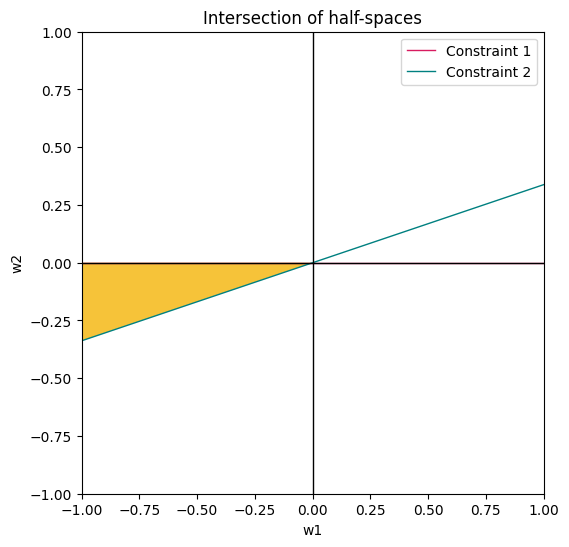

In [14]:
plot_halfspace_intersection_2d(U_global)

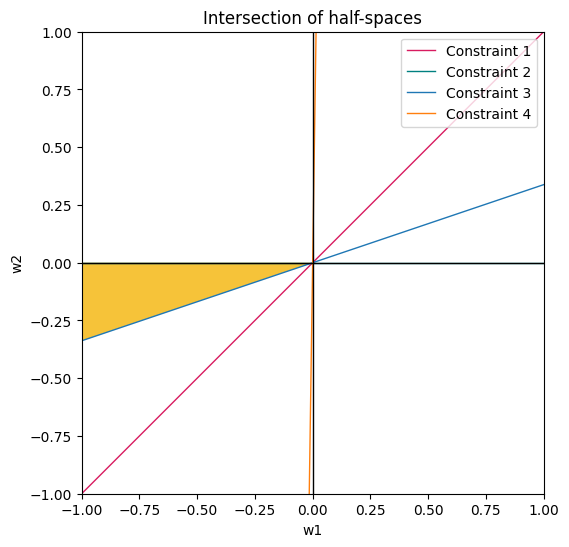

In [15]:
plot_halfspace_intersection_2d(U_global_)

In [ ]:
for i, u in enumerate(U_per_mdp):
    plot_halfspace_intersection_2d(u, title=f"env{i}")

In [ ]:
# --- 3) Candidate demos per MDP (greedy policy rollouts from Q) ---
candidates = generate_candidates_from_q_family(
    envs,
    envs_Q,
    num_rollouts_per_state=5,   # adjust as you like
    max_steps=1,
    tie_eps=1e-10,
)

# --- 4) Unweighted greedy cover over family constraints ---
chosen = scot_greedy_family_unweighted(
    U_global=U_global,
    candidates=candidates,
    SFs=SFs,
    normalize=True,
    round_decimals=12,
)
# chosen is: List[(mdp_index, trajectory_list_of_(s,a))]
# Example: [(0, [(s0,a2), (s5,a1), ...]), (1, [...]), ...]

In [ ]:
chosen

In [ ]:
# from collections import defaultdict

# def merge_chosen(chosen):
#     merged = defaultdict(list)
#     for env_idx, traj in chosen:
#         if traj:  # skip empty ones
#             merged[env_idx].extend(traj)
#     # convert to sorted list of tuples
#     return [(i, merged[i]) for i in sorted(merged.keys())]


# demos_by_env = merge_chosen(chosen)

# birlf = MultiEnvBIRL(envs=envs, demos=demos_by_env, beta=10, epsilon=1e-4)
# birlf.run_mcmc(samples=2000, stepsize=0.1, normalize=True, adaptive=True)
# w_map  = birlf.get_map_solution()
# w_mean = birlf.get_mean_solution(burn_frac=0.2, skip_rate=10)

# ---- main: solve & print policies for all envs using MAP weights ----
# def print_policies_with_map(birl, shapes=None, tie_eps=1e-8):
#     """
#     birl: MultiEnvBIRL instance already run (has map_sol)
#     shapes: optional list/dict mapping env index -> (rows, cols)
#             e.g., shapes={0:(5,7), 1:(4,4)} or list like [(5,7),(4,4),...]
#     """
#     w_map = birl.get_map_solution()
#     assert w_map is not None, "MAP solution is None. Run birl.run_mcmc(...) first."

#     for i, env in enumerate(birl.envs):
#         # Set weights and solve VI fresh
#         env.set_feature_weights(w_map)
#         vi = ValueIteration(env)
#         vi.run_value_iteration(epsilon=getattr(birl, "epsilon", 1e-4))
#         Q = vi.get_q_values()

#         # terminals if available
#         ts = getattr(env, "terminal_states", []) or []


#         rows, cols = (shapes[i] if isinstance(shapes, (list, tuple)) else shapes[i])

#         #print(f"=== Env {i} | rows={rows}, cols={cols} ===")
#         print_policy_from_q(Q, rows, cols, tie_eps=tie_eps, terminal_states=ts)

### evaluating SCOT against random strategy

In [ ]:
def merge_chosen(chosen):
    merged = defaultdict(list)
    for env_idx, traj in chosen:
        if traj:  # skip empty ones
            merged[env_idx].extend(traj)
    # convert to sorted list of tuples
    return [(i, merged[i]) for i in sorted(merged.keys())]

def compute_Q_from_weights_with_VI(env, w, vi_epsilon=1e-6):
    old_w = None
    if hasattr(env, "get_feature_weights") and callable(getattr(env, "get_feature_weights")):
        old_w = env.get_feature_weights()
    elif hasattr(env, "feature_weights"):
        old_w = np.array(env.feature_weights, copy=True)

    env.set_feature_weights(w)
    vi = ValueIteration(env)
    vi.run_value_iteration(epsilon=vi_epsilon)
    Q = vi.get_q_values()

    if old_w is not None:
        env.set_feature_weights(old_w)
    return Q

def regrets_from_Q(envs, Q_list, *, tie_eps=1e-10, epsilon=1e-4, normalize_with_random_policy=False):
    if len(Q_list) != len(envs):
        raise ValueError(f"Q_list length {len(Q_list)} must match envs length {len(envs)}")
    regs = []
    for idx, (env, Q) in enumerate(zip(envs, Q_list)):
        if Q is None:
            raise ValueError(f"Q_list[{idx}] is None")
        pi = build_Pi_from_q(env, Q, tie_eps=tie_eps)
        r = calculate_expected_value_difference(
            eval_policy=pi,
            env=env,
            epsilon=epsilon,
            normalize_with_random_policy=normalize_with_random_policy,
        )
        regs.append(float(r))
    return np.asarray(regs, dtype=float)

def birl_to_Q_lists(envs, demos_by_env, *, beta=10, epsilon=1e-4,
                    samples=2000, stepsize=0.1, normalize=True, adaptive=True,
                    burn_frac=0.2, skip_rate=10, vi_epsilon=1e-6):
    birl = MultiEnvBIRL(envs=envs, demos=demos_by_env, beta=beta, epsilon=epsilon)
    birl.run_mcmc(samples=samples, stepsize=stepsize, normalize=normalize, adaptive=adaptive)
    w_map  = birl.get_map_solution()
    w_mean = birl.get_mean_solution(burn_frac=burn_frac, skip_rate=skip_rate)
    if w_map is None or w_mean is None:
        raise RuntimeError("BIRL did not return weights (w_map or w_mean is None).")

    Q_map_list  = [compute_Q_from_weights_with_VI(env, w_map,  vi_epsilon=vi_epsilon)  for env in envs]
    Q_mean_list = [compute_Q_from_weights_with_VI(env, w_mean, vi_epsilon=vi_epsilon) for env in envs]
    return (w_map, w_mean, Q_map_list, Q_mean_list, birl)

def run_scot_vs_random_Q_regret(
    envs,
    chosen_scot,                  # [(env_i, [(s,a), ...]), ...]
    make_random_chosen,           # callable: seed -> [(env_i, [(s,a), ...]), ...]
    *,
    n_random_trials=10,
    seeds=None,
    birl_kwargs=None,
    vi_epsilon=1e-6,
    tie_eps=1e-10,
    regret_epsilon=1e-4,
    normalize_regret=False,
):
    m = len(envs)
    birl_kwargs = birl_kwargs or {}

    # ----- SCOT -----
    #demos_scot = group_demos_by_env(chosen_scot, m)
    demos_scot = merge_chosen(chosen_scot)
    w_scot_map, w_scot_mean, Q_scot_map, Q_scot_mean, birl_scot = birl_to_Q_lists(
        envs, demos_scot, vi_epsilon=vi_epsilon, **birl_kwargs
    )

    reg_scot_map  = regrets_from_Q(envs, Q_scot_map,
                                   tie_eps=tie_eps, epsilon=regret_epsilon,
                                   normalize_with_random_policy=normalize_regret)
    reg_scot_mean = regrets_from_Q(envs, Q_scot_mean,
                                   tie_eps=tie_eps, epsilon=regret_epsilon,
                                   normalize_with_random_policy=normalize_regret)

    # ----- Random (multi-seed) -----
    if seeds is None:
        seeds = list(range(n_random_trials))

    rand_map_regs_by_seed  = []
    rand_mean_regs_by_seed = []

    for sd in seeds:
        chosen_rand = make_random_chosen(sd)  # must match chosen_scot shape
        demos_rand  = merge_chosen(chosen_rand)
        
        _, _, Q_rand_map, Q_rand_mean, _ = birl_to_Q_lists(
            envs, demos_rand, vi_epsilon=vi_epsilon, **birl_kwargs
        )

        reg_rand_map  = regrets_from_Q(envs, Q_rand_map,
                                       tie_eps=tie_eps, epsilon=regret_epsilon,
                                       normalize_with_random_policy=normalize_regret)
        reg_rand_mean = regrets_from_Q(envs, Q_rand_mean,
                                       tie_eps=tie_eps, epsilon=regret_epsilon,
                                       normalize_with_random_policy=normalize_regret)

        rand_map_regs_by_seed.append(reg_rand_map)
        rand_mean_regs_by_seed.append(reg_rand_mean)

    rand_map_regs_by_seed  = np.stack(rand_map_regs_by_seed,  axis=0)  # (T, M)
    rand_mean_regs_by_seed = np.stack(rand_mean_regs_by_seed, axis=0)  # (T, M)

    # Averages (per env)
    rand_map_per_env_mean  = rand_map_regs_by_seed.mean(axis=0)
    rand_mean_per_env_mean = rand_mean_regs_by_seed.mean(axis=0)

    def _stats(x):
        return dict(mean=float(np.mean(x)), std=float(np.std(x)),
                    median=float(np.median(x)), min=float(np.min(x)), max=float(np.max(x)))

    return {
        "SCOT": {
            "w_map": w_scot_map,
            "w_mean": w_scot_mean,
            "regret_map_per_env":  reg_scot_map,
            "regret_mean_per_env": reg_scot_mean,
            "summary_map":  _stats(reg_scot_map),
            "summary_mean": _stats(reg_scot_mean),
        },
        "RANDOM_over_seeds": {
            "regret_map_by_seed":  rand_map_regs_by_seed,
            "regret_mean_by_seed": rand_mean_regs_by_seed,
            "per_env_seed_mean_map":  rand_map_per_env_mean,
            "per_env_seed_mean_mean": rand_mean_per_env_mean,
            "summary_seed_mean_map":  _stats(rand_map_per_env_mean),
            "summary_seed_mean_mean": _stats(rand_mean_per_env_mean),
            "seeds": seeds,
        },
        "Q_lists": {
            "SCOT_MAP":  Q_scot_map,
            "SCOT_MEAN": Q_scot_mean,
        },
        "birl": {"SCOT": birl_scot},
        "config": {
            "vi_epsilon": vi_epsilon,
            "regret_epsilon": regret_epsilon,
            "tie_eps": tie_eps,
            "normalize_regret": normalize_regret,
        }
    }

In [ ]:
def make_random_chosen(seed):
    return sample_optimal_sa_pairs_like_scot(
        envs, Q_list=envs_Q, chosen_from_scot=chosen,
        tie_eps=1e-10, skip_terminals=True, seed=seed, return_shape="scot"
    )

birl_kwargs = dict(beta=10, epsilon=1e-4, samples=3000, stepsize=0.1,
                   normalize=True, adaptive=True, burn_frac=0.1, skip_rate=10)

results = run_scot_vs_random_Q_regret(
    envs=envs,
    chosen_scot=chosen,
    make_random_chosen=make_random_chosen,
    n_random_trials=5,
    birl_kwargs=birl_kwargs,
    vi_epsilon=1e-6,
    tie_eps=1e-10,
    regret_epsilon=1e-4,
    normalize_regret=False,
)

print("SCOT mean regret (MAP):",  results["SCOT"]["summary_map"]["mean"])
print("Random mean regret (MAP, avg over seeds):",
      results["RANDOM_over_seeds"]["summary_seed_mean_map"]["mean"])